# Bikers on the Fremont bridge
Example adapted from the [Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

## Set up: Download (and load) data

In [22]:
# Download data(you can download it by uncommenting and runing this line of code)
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
%matplotlib inline

In [23]:
# Aggregate data to the daily level
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

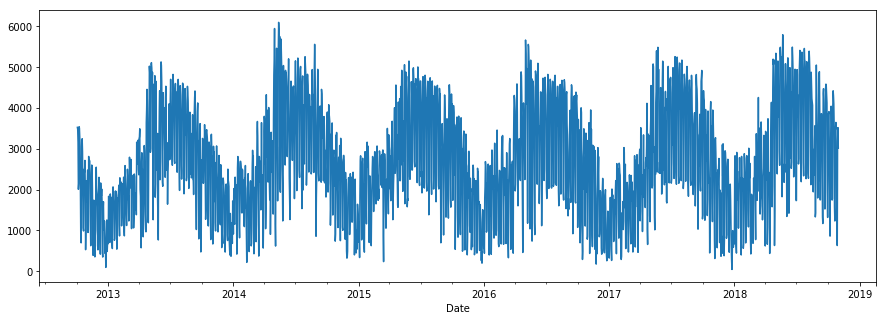

In [24]:
plt.figure(figsize=(15,5))
daily.Total.plot()

In [25]:
daily[daily.Total == daily.Total.max()]

,Total
Date,
2014-05-13,6088.0


# Data Prep: Adding Features

In [26]:
# Load weather data (downloaded from: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)
weather = pd.read_csv('data/weather.csv', index_col='DATE', parse_dates=True)

# Create dry_day column
weather['dry_day'] = (weather['PRCP'] == 0).astype(int)

In [27]:
# Join selected weather columns
daily = daily.join(weather[['PRCP', 'dry_day', 'TMIN', 'TMAX']])

(8, 17)

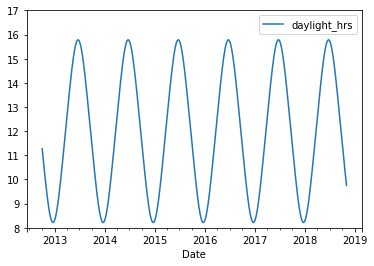

In [28]:
# Compute hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

# Feature Generation: Categorical Variable(s)

In [29]:
# Get dummy variables from categorical columns (alternative: sklearn OneHotEncoding)
daily["day_of_week"] = daily.index.day_name()
# daily["day_of_week"] = daily.index.dayofweek.astype(dtype="str")
daily = pd.get_dummies(daily)
daily.head()

,Total,PRCP,dry_day,TMIN,TMAX,daylight_hrs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,1,46.0,66.0,11.277359,0,0,0,0,0,0,1
2012-10-04,3475.0,0.0,1,47.0,66.0,11.219142,0,0,0,0,1,0,0
2012-10-05,3148.0,0.0,1,48.0,71.0,11.161038,1,0,0,0,0,0,0
2012-10-06,2006.0,0.0,1,46.0,75.0,11.103056,0,0,1,0,0,0,0
2012-10-07,2142.0,0.0,1,46.0,75.0,11.045208,0,0,0,1,0,0,0


# Abbreviated EDA

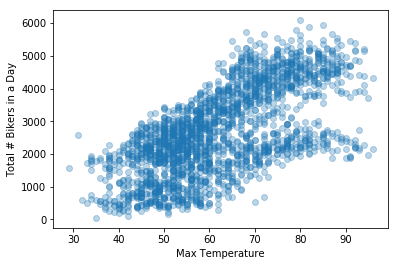

In [43]:
# What is the relationship between bikers and temperature?
plt.scatter(daily.TMAX, daily.Total, alpha = 0.2)
plt.xlabel("Max Temperature")
plt.ylabel("Total # Bikers in a Day")
plt.show()

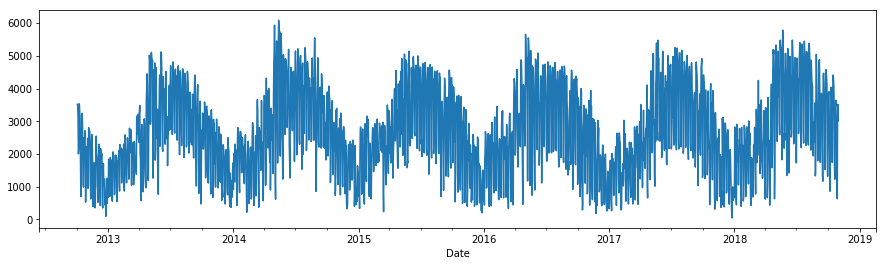

In [41]:
# What is the relationship between bikers and date?
plt.figure(figsize=(15,4))
daily.Total.plot()

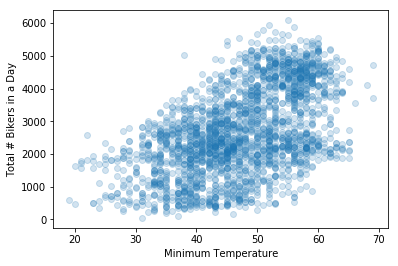

In [45]:
# What is the relationship between bikers and (min) temperature?
plt.scatter(daily.TMIN, daily.Total, alpha = 0.2)
plt.xlabel("Minimum Temperature")
plt.ylabel("Total # Bikers in a Day")
plt.show()

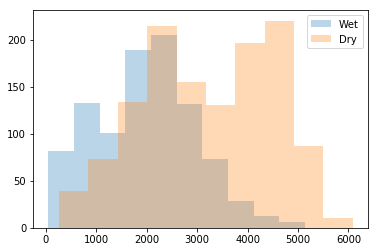

In [50]:
# What is the distribution of bikers on dry/wet days?
wet_days = daily[daily.dry_day == 0]
dry_days = daily[daily.dry_day == 1]
plt.hist(wet_days.Total, alpha = 0.3, label = "Wet")
plt.hist(dry_days.Total, alpha = 0.3, label = "Dry")
plt.legend()
plt.show()

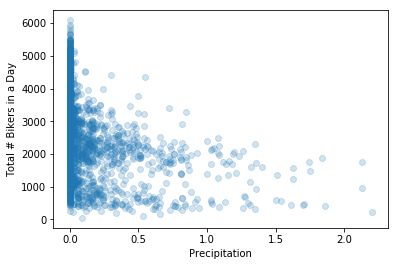

In [53]:
# What is the relationship between bikers and precipitation?
plt.scatter(daily.PRCP, daily.Total, alpha = 0.2)
plt.xlabel("Precipitation")
plt.ylabel("Total # Bikers in a Day")
plt.show()

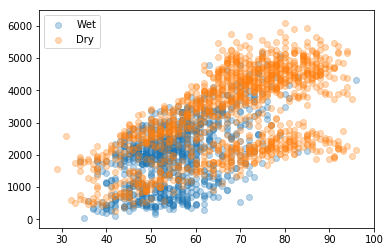

In [56]:
# How does the number of bikers vary by temperature and wet/dry?
plt.scatter(wet_days.TMAX, wet_days.Total, alpha = 0.3, label = "Wet")
plt.scatter(dry_days.TMAX, dry_days.Total, alpha = 0.3, label = "Dry")
plt.legend()
plt.show()

# Modeling: KNN Regressor

In [57]:
# Split data into training and testing data
# Split into test/train data
from sklearn.model_selection import train_test_split
train_features, test_features, train_outcome, test_outcome = train_test_split(
    daily.drop("Total", axis = 1), 
    daily.Total, 
    test_size=0.10
)

In [71]:
# Create a scaler and your classifier
scaler = MinMaxScaler()
knn_clf = KNeighborsRegressor()


# Define a pipeline that uses your scaler and classifier
pipe = make_pipeline(scaler, knn_clf)

# Define a grid to search through
params = {"kneighborsregressor__n_neighbors":np.arange(1, 10)}

# Perform a grid search of your pipeline
grid_search = GridSearchCV(pipe, params, scoring="neg_mean_absolute_error")
grid_search.fit(train_features, train_outcome)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kneighborsregressor__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

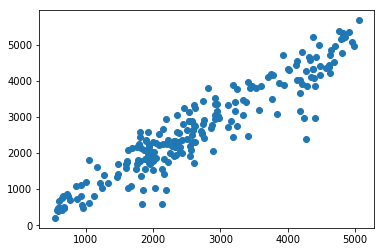

In [72]:
# Compare prediction to (test) data
preds = grid_search.predict(test_features)
plt.scatter(preds, test_outcome)
plt.show()

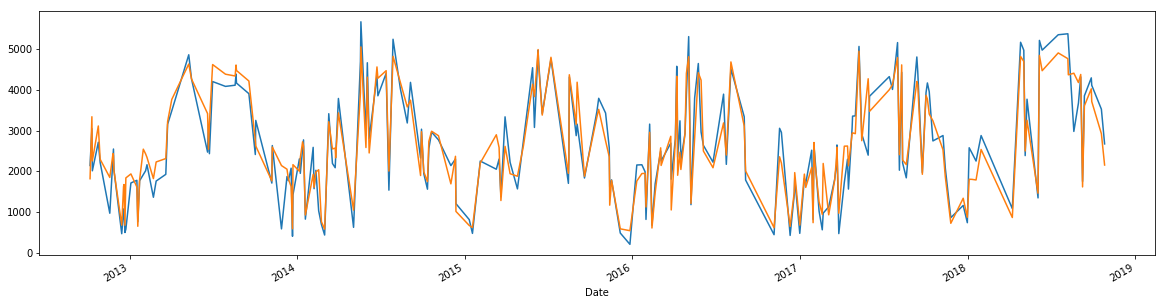

In [73]:
test_data = test_features.join(test_outcome)
test_data["preds"] = grid_search.predict(test_features)
plt.figure(figsize=(20, 5))
test_data.Total.plot(label = "Actual")
test_data.preds.plot(label = "Predicted")
plt.show()

In [74]:
grid_search.score(test_features, test_outcome)

-334.8063063063063

# Feature Generation: Polynomial Transformations

In [75]:
# Add a polynomial transformation to the pipeline
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()

In [77]:
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, knn_clf)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4),
             'kneighborsregressor__n_neighbors':range(1, 10),
             'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid_search = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid_search.fit(train_features, train_outcome)
grid_search.score(test_features, test_outcome)

-335.86417596312697

In [17]:
# Visualize time trends


# Error assessment: find systematic errors

In [18]:
# Why are we getting this wrong?
# Assess error by day of the week


In [19]:
# Assess error by temperature and dry_day


In [20]:
# Assess error by precipitation


# Feature Selection: Select best features
As a form of dimensionality reduction, only select the top percentile features that have a certain threshold of variance.

In [21]:
# Create a percentile selector, add it to the pipeline
# (alternatives a K selectors, PCA, or others)


# Define a grid to search through (including the degree of polynomial AND percentile of best features)


In [22]:
# Fit the model